In [1]:
import numpy as np
import skimage as sk
import skimage.io as skio
from skimage.transform import rescale, resize, downscale_local_mean
from scipy.signal import *
import matplotlib.pyplot as plt
import cv2
import scipy

In [2]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

### Helper Functions

In [4]:
def crop_edges(im, percent):
    if percent > 0.5:
        print('Error')
    x_cut = int(im.shape[1] * percent)
    y_cut = int(im.shape[0] * percent)
    return im[y_cut:-y_cut, x_cut:-x_cut]

In [5]:
def loader(imname, gray=False):
    im = skio.imread(imname, as_gray=gray)

    # Convert to Double
    im = sk.img_as_float(im)
    return im

# Main

## 1 - Fun with Filters

### 1.1 - Finite Difference Operator

#### Image Loading

imname = 'cameraman.png'

# Read Image
im = skio.imread(imname, as_gray=True)

# Convert to Double
im = sk.img_as_float(im)

skio.imshow(im)
skio.show()


#### X-gradient

Dx = np.matrix([1,-1])
x_gradient = convolve2d(im, Dx, mode='same')
skio.imshow(x_gradient, cmap=plt.cm.gray)

plt.hist(np.matrix.flatten(x_gradient));
plt.title('Distribution of X Gradients');

def threshold(i):
    testje = x_gradient.copy()
    testje[(testje < i) & (testje > -1*i )] = 0
    testje[(testje != 0)] = 1
    skio.imshow(testje, cmap=plt.cm.gray)
    return testje

from ipywidgets import FloatSlider

interact(threshold, i=FloatSlider(min=0, max=1, step=1e-5));

clean_x_grd = threshold(0.22)

### Y-gradient

Dy = np.matrix([1,-1]).T
y_gradient = convolve2d(im, Dy, mode='same')
skio.imshow(y_gradient, cmap=plt.cm.gray)

plt.hist(np.matrix.flatten(y_gradient));
plt.title('Distribution of Y Gradients');

def threshold_y(i):
    testje = y_gradient.copy()
    testje[(testje < i) & (testje > -1*i )] = 0
    testje[(testje != 0)] = 1
    skio.imshow(testje, cmap=plt.cm.gray)
    return testje

from ipywidgets import FloatSlider

interact(threshold_y, i=FloatSlider(min=0, max=1, step=1e-5));

clean_y_grd = threshold_y(0.17)

skio.imshow(np.sqrt(clean_x_grd **2 + clean_y_grd **2))

#Saving results in the output folder
skio.imsave('outputs/1.1-X-Gradient-Edge.jpg', clean_x_grd);
skio.imsave('outputs/1.1-Y-Gradient-Edge.jpg', clean_y_grd);

### 1.2 - 

In lecture, we talked about how the half-width of a kernel size should be about 3 sigma. Therefore, I have decided to pick sigma 3 for a kernel size of 20.

gauss1d = cv2.getGaussianKernel(20, 3)
gauss2d = gauss1d @ gauss1d.T

blurred_gauss = convolve2d(im, gauss2d)
skio.imshow(blurred_gauss)

### Filter and then Gradient (2-Step)

def threshold(i, y_gradient):
    testje = y_gradient.copy()
    testje[(testje < i) & (testje > -1*i )] = 0
    testje[(testje != 0)] = 1
    skio.imshow(testje, cmap=plt.cm.gray)
    return testje

#### X

GDX = threshold(0.02, convolve2d(convolve2d(im, Dx, mode="same"),gauss2d))
skio.imsave('outputs/1.2-X-Gradient-2STEP.jpg', GDX);

#### Y

GDY = threshold(0.02, convolve2d(convolve2d(im, Dy, mode="same"), gauss2d))
skio.imsave('outputs/1.2-Y-Gradient-2STEP.jpg', GDY);

gY = convolve2d(convolve2d(im, Dy, mode="same"), gauss2d)
gX = convolve2d(convolve2d(im, Dx, mode="same"), gauss2d)

mag = np.sqrt(gX ** 2 + gY **2)

skio.imshow(mag)

In [29]:
skio.imsave('outputs/1.2-XY-Gradient-2STEP.jpg', np.clip(GDY + GDX, a_min=0, a_max=1));

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


### Gradient Filters (1-Step)

#### Gaussian/Dx Filter

In [30]:
DxGauss = convolve2d(gauss2d, Dx)

(array([1.58700e+03, 1.32100e+03, 3.42400e+03, 7.78200e+03, 2.23860e+04,
        2.55139e+05, 1.29870e+04, 6.56200e+03, 2.93000e+03, 4.20000e+01]),
 array([-0.12643012, -0.10226539, -0.07810067, -0.05393594, -0.02977121,
        -0.00560648,  0.01855825,  0.04272297,  0.0668877 ,  0.09105243,
         0.11521716]),
 <a list of 10 Patch objects>)

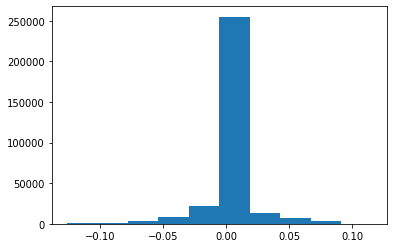

In [31]:
DoGX = convolve2d(im, DxGauss)
plt.hist(np.matrix.flatten(DoGX))

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


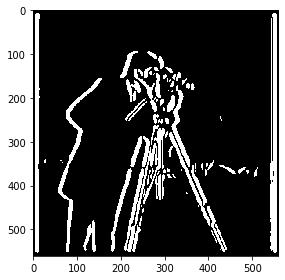

In [32]:
DoGX = threshold(0.02, DoGX)
skio.imsave('outputs/1.2-X-Gradient-1STEP.jpg', DoGX);

#### Gaussian/Dy Filter

In [33]:
DyGauss = convolve2d(gauss2d, Dy)

(array([7.80000e+01, 1.38400e+03, 4.59300e+03, 1.48100e+04, 2.62362e+05,
        2.28520e+04, 3.88900e+03, 1.47300e+03, 5.87000e+02, 2.13000e+03]),
 array([-0.11529486, -0.09066332, -0.06603179, -0.04140026, -0.01676872,
         0.00786281,  0.03249434,  0.05712588,  0.08175741,  0.10638895,
         0.13102048]),
 <a list of 10 Patch objects>)

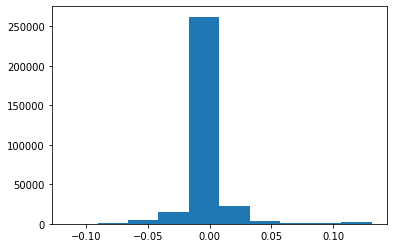

In [34]:
DoGY = convolve2d(im, DyGauss)
plt.hist(np.matrix.flatten(DoGY))

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


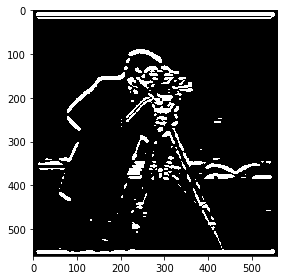

In [35]:
DoGY = threshold(0.02, DoGY)
skio.imsave('outputs/1.2-Y-Gradient-1STEP.jpg', DoGY);

## Utility: `Gradient`

### 1.3 - Straightening Images

In [36]:
imname = 'facade.jpg'

# Read Image
img = skio.imread(imname, as_gray=True)

# Convert to Double
img = sk.img_as_float(img)

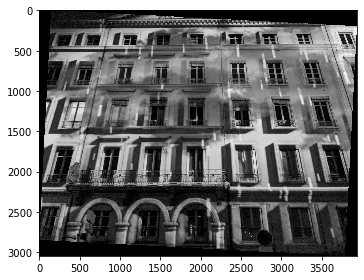

In [37]:
skio.imshow(np.clip(scipy.ndimage.interpolation.rotate(img, angle=-3), a_max=1, a_min=0));

In [38]:
rota = np.clip(scipy.ndimage.interpolation.rotate(img, angle=0), a_max=1, a_min=0)

In [39]:
rotated = crop_edges(rota, 0.4)

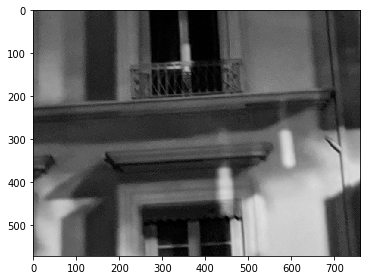

In [40]:
skio.imshow(rotated)

In [41]:
Dx = np.matrix([1,-1])
x_gradi = convolve2d(rotated, Dx, mode='same')

In [42]:
Dy = np.matrix([1,-1]).T
y_gradi = convolve2d(rotated, Dy, mode='same')

In [43]:
angles = np.degrees(np.arctan2(-1 * y_gradi, x_gradi))

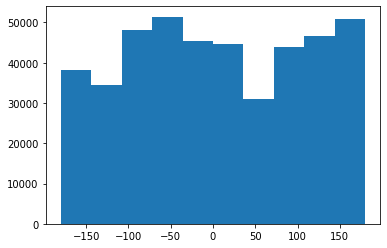

In [44]:
plt.hist(np.matrix.flatten(angles));

(array([38172., 34471., 48148., 51411., 45427., 44515., 31029., 43876.,
        46701., 50781.]),
 array([-180., -144., -108.,  -72.,  -36.,    0.,   36.,   72.,  108.,
         144.,  180.]),
 <a list of 10 Patch objects>)

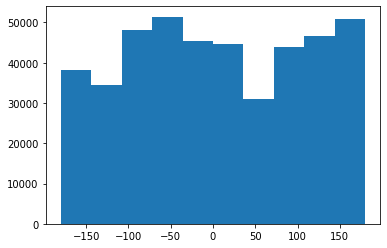

In [45]:
plt.hist(np.matrix.flatten(angles))

In [46]:
num = np.count_nonzero(angles == 90)+ np.count_nonzero(angles == -90)+ np.count_nonzero(angles == -180) + np.count_nonzero(angles == 180)

In [47]:
num

22642

In [48]:
def straigthen(imname, crop_edge=0.10, rotations = np.arange(-10, 11),show=True, hist=False, hist_saving=False, hist_show =False):
    imname = imname

    # Read Image
    color = skio.imread(imname)
    img = skio.imread(imname, as_gray=True)

    # Convert to Double
    img = sk.img_as_float(img)
    
    best_rotation, best_score = None, None
    
    for deg in rotations:
        print(deg, sep=' ', end='', flush=True)
        if deg == 0:
            continue
        rota = np.clip(scipy.ndimage.interpolation.rotate(img, angle=deg), a_max=1, a_min=0)
        rotated = crop_edges(rota, crop_edge)
        gauss1d = cv2.getGaussianKernel(20, 3)
        gauss2d = gauss1d @ gauss1d.T
        Dx = convolve2d(gauss2d, np.matrix([1,-1]))
        x_gradi = convolve2d(rotated, Dx, mode='same')
        Dy = convolve2d(gauss2d, np.matrix([1,-1]).T)
        y_gradi = convolve2d(rotated, Dy, mode='same')
        angles = np.matrix.flatten(np.round(np.degrees(np.arctan2(-1 * y_gradi, x_gradi))))
        
        if hist:
            if hist_show:
                plt.hist(angles);
            if hist_saving:
                plt.savefig(f"outputs/1.3-Straigthening-Histograms/Rotation_Angles_{deg}")
            plt.clf()
        num = (np.count_nonzero(angles == 90)+ np.count_nonzero(angles == -90)) / len(angles)
#         print(num)
#         print(deg)
        
        if best_score == None or num > best_score:
#             print(deg)
            best_rotation = deg
            best_score = num
    
    
    returning = scipy.ndimage.interpolation.rotate(color, angle=best_rotation)
    
    if show:
        skio.imshow(returning)
        print(f"Straightening accomplished by rotating with degree {best_rotation}")
    
    return returning
        
    

-10-9-8-7-6-5-4-3-2-1012345678910Straightening accomplished by rotating with degree -3


array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

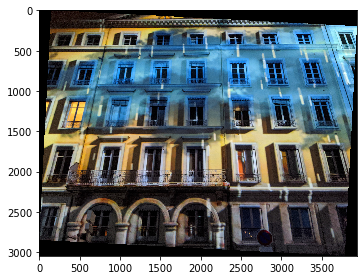

In [49]:
straigthen('facade.jpg', show=True, crop_edge=0.4, hist=True,hist_show=True)

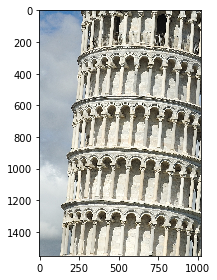

In [478]:
skio.imshow(crop_edges(loader('pisa.jpeg'),0.3))

-10-9-8-7-6-5-4-3-2-1012345678910Straightening accomplished by rotating with degree 5


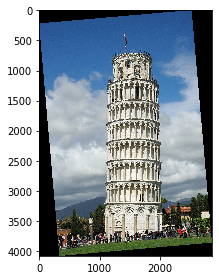

In [482]:
pisa = straigthen('pisa.jpeg', show=True, crop_edge=0.3,  hist=True, hist_saving=True, hist_show = True)

In [483]:
skio.imsave("outputs/pisa_str.jpg", pisa)

-10-9-8-7-6-5-4-3-2-1012345678910Straightening accomplished by rotating with degree -5


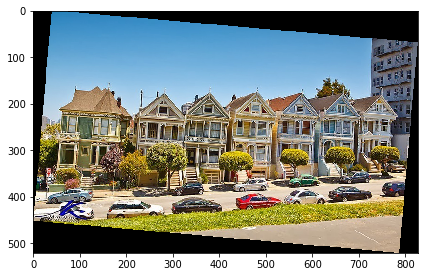

In [484]:
SF = straigthen('ptd.jpg', show=True, crop_edge=0.3,hist=True, hist_saving=True, hist_show = True )

In [487]:
skio.imsave("outputs/Berk_str.jpg", tree)

-10-9-8-7-6-5-4-3-2-1012345678910Straightening accomplished by rotating with degree 7


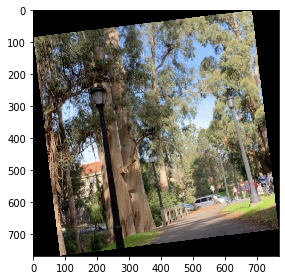

In [486]:
tree = straigthen('trees12.jpg', show=True, crop_edge=0.3, hist=True, hist_saving=True, hist_show = True )

## 2 - Fun with Frequencies

### 2.1 - Image Sharpening

In [54]:
gauss1d = cv2.getGaussianKernel(20, 3)
gauss2d = gauss1d @ gauss1d.T

In [55]:
def three_d_convolve(im, kernel):
    im_r = im[:,:,0].copy()
    im_g = im[:,:,1].copy()
    im_b = im[:,:,2].copy()
    blur_im = np.dstack([convolve2d(x, kernel, mode='same') for x in [im_r, im_g, im_b]])
    return blur_im

In [56]:
def sharpener(imname, alpha, savename='', show=True, grey=False, crop_edge = None, clip=True, gaus_ksize = 20, gaus_std = 3):

    # Read Image
    im = skio.imread(imname)

    # Convert to Double
    im = sk.img_as_float(im)
    
    #Kernel
    gauss1d = cv2.getGaussianKernel(gaus_ksize, gaus_std)
    gauss2d = gauss1d @ gauss1d.T
    
    if ~grey:
        blur_im = three_d_convolve(im, gauss2d)
    else:
        blur_im = convolve2d(im, gauss2d, mode='same')
    
    high_fq_im = im.copy()
    if ~grey:
        high_fq_im[:,:,0] = im[:,:,0] -blur_im[:,:,0]
        high_fq_im[:,:,1] = im[:,:,1] -blur_im[:,:,1]
        high_fq_im[:,:,2] = im[:,:,2] -blur_im[:,:,2]
    output = im + alpha * high_fq_im
    
    if clip:
        output = np.clip(output, a_min = 0, a_max = 1)
    
    if crop_edge != None:
        output = crop_edges(output, crop_edge)
    
    if show:
        skio.imshow(output)
    
    if savename == '':
        savename = f'outputs/{imname}_sharpened.jpg'
    skio.imsave(savename, output)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


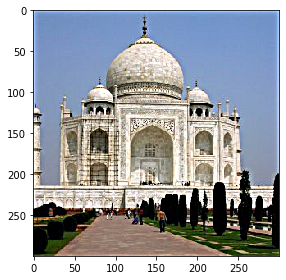

In [57]:
sharpener('taj.jpg', 1, savename='outputs/2.1-SharpTaj.jpg', show=True)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


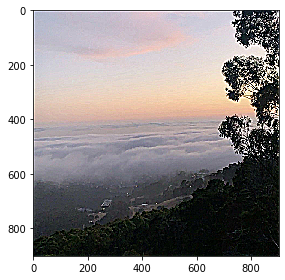

In [58]:
sharpener('berk.jpg', 5, savename='outputs/2.1-berk.jpg', show=True)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


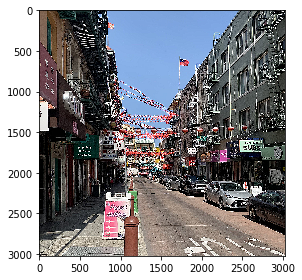

In [59]:
sharpener('chinatown.jpg', 2, savename='outputs/2.1-ctown.jpg', show=True)

#### Blur - Sharpen - Blur - Compare

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


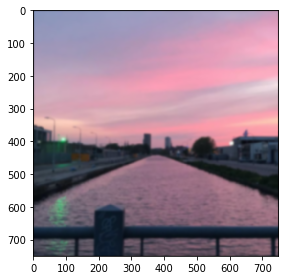

In [60]:
ehv_blur = three_d_convolve(loader('EINDHOVEN.JPEG'), gauss2d)
skio.imshow(ehv_blur)
skio.imsave('outputs/2.1B-EHV-Blur.jpg', ehv_blur)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


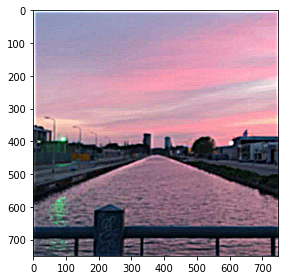

In [61]:
sharpener('outputs/2.1B-EHV-Blur.jpg', 5, savename='outputs/2.1B-EHV-Blur-Sharp.jpg', show=True)

### 2.2 - Hybrid Images

#### See document containing 2.2

In [156]:
def gaussian_blur(im, value, size=False):
    if len(im.shape) == 2:
        gauss2d = gaussian_kernel(value, size)
        return convolve2d(im, gauss2d, mode="same")
    else:
        result = im.copy()
        for i in range(0,3):
            gauss2d = gaussian_kernel(value, size)
            result[:,:,i] = convolve2d(im[:,:,i], gauss2d, mode='same')
        return result

In [157]:
def alignment_pic(ima1='nutmeg.jpg', ima2='DerekPicture.jpg'):
    """Align two pictures with each other. Image 1 is rotated to be aligned with image 2.
    ima1, ima2: (2D/3D Matrices)
    
    Return 2 2D/3D Matrices of alignment.
    
    
    Note: make sure to toggle `matplotlib.use('TkAgg') or another GUI tool to manually select alignment"""
    from align_image_code import align_images
    
    # high sf
    im2 = plt.imread(ima2)/255.

    # low sf
    im1 = plt.imread(ima1)/255

    # Next align images (this code is provided, but may be improved)
    im1_aligned, im2_aligned = align_images(im1, im2)
    return im1_aligned, im2_aligned

def gaussian_kernel(value, size=False):
    """Calculate the gaussian kernel filter.
    Default is that size = False. That means that the value passed in is a standard deviation.
    If size is True, then that means we pass in a kernel width/height and sigma will be precalculated. Dependencies of this functions are the gaussian blur function.
    Value: (Int) Either standard deviation or desired kernel width/height
    Size: (Bool) True: `value` is kernel width; False: 'Value' is the gaussian sigma
    
    Returns: (2D Matrix) Gaussian Filter """
    if size:
        size = value
        standard_deviation = int(size/6)
        gauss1d = cv2.getGaussianKernel(value, standard_deviation)
        gauss2d = gauss1d @ gauss1d.T
        return gauss2d
    else:
        standard_deviation = value
        size = int(standard_deviation) * 6
        gauss1d = cv2.getGaussianKernel(size, standard_deviation)
        gauss2d = gauss1d @ gauss1d.T
        return gauss2d

def hybrid_images(im1, im2, sigma1, sigma2, debug=False, align=True, reverse_align=False):
    """im1, im2: (2D/3D matrix or filename) Input images (Image 1 is high frequency, Image 2 is low frequency)
    sigma1, sigma2: (int) Standard Deviations to be applied to obtain their gaussian blurs
    debug: debugging mode
    align: (Bool) if alignment is desired
    reverse_align: (Bool) Generally, im1 is aligned to be rotated with im2. If the reverse alignment is desired, please enter True

    Returns: (2D/3D matrix) of hybrid image"""
    if reverse_align and align:
        im1, im2 = im2, im1

    if align and type(im1) != str:
        import matplotlib
        matplotlib.use('TkAgg')
    #         assert im1.shape == im2.shape, "The two matrices are not the same size"
        im1_aligned, im2_aligned = align_images(im1, im2)

    if align and type(im1) == str:
        import matplotlib
        matplotlib.use('TkAgg')
        im1_aligned, im2_aligned = alignment_pic(im1, im2)


    if reverse_align and align:
        im1_aligned, im2_aligned = im2_aligned, im1_aligned

    if len(im1_aligned.shape) == 3:
        blur = im1_aligned.copy()
        highfq = im2_aligned.copy()
        for i in range(0,3):
            gauss2d1 = gaussian_kernel(sigma1)
            gauss2d2 = gaussian_kernel(sigma2)
            blur[:,:,i] = convolve2d(im2_aligned[:,:,i], gauss2d1, mode='same')
            highfq[:,:,i] = im1_aligned[:,:,i] - convolve2d(im1_aligned[:,:,i], gauss2d2, mode='same')
        hybrid = np.clip(blur+highfq, a_min=0, a_max=1)
    else:
        gauss2d1 = gaussian_kernel(sigma1)
        gauss2d2 = gaussian_kernel(sigma2)
        blur = convolve2d(np.mean(im2_aligned, axis=2), gauss2d1, mode='same')
        highfq = np.mean(im1_aligned, axis=2) - convolve2d(np.mean(im1_aligned, axis=2), gauss2d2, mode='same')
        hybrid = np.clip(blur+highfq, a_min=0, a_max=1)
    if debug:
        %matplotlib inline
        skio.imshow(hybrid)
    return hybrid


### 2.3 - Gaussian and LaPlacian Stacks

In [419]:
def gaussian_stack(im, level, sigma, debug=False):
    result = [im]
    
    for i in np.arange(1, level + 1):
        result += [gaussian_blur(result[-1], sigma)]
    return np.array(result)

In [493]:
mona = skio.imread("mona.jpg")/255.

In [494]:
def laplacian_stack(im, level, sigma, debug=False):
    gausstack = gaussian_stack(im, level, sigma)
    result = []
    for i in range(len(gausstack)-1):
        result += [(gausstack[i] - gausstack[i+1])]
    result += [gausstack[-1]]
    return np.array(result)
        

In [423]:
mona_gauss = gaussian_stack(mona, 4, 3)

In [495]:
mona_laplace = laplacian_stack(mona, 4,3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


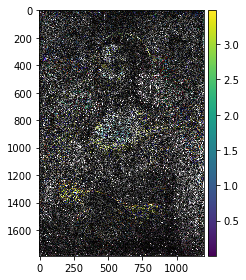

In [504]:
skio.imshow(4*np.abs(mona_laplace[0]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


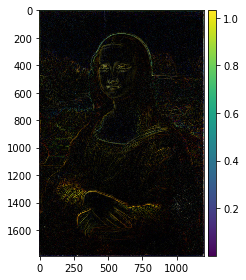

In [507]:
skio.imshow(10*np.abs(mona_laplace[1]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


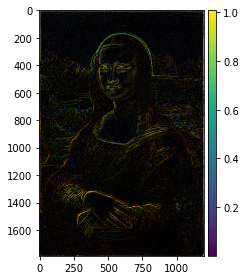

In [509]:
skio.imshow(15*np.abs(mona_laplace[2]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


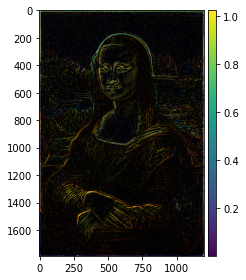

In [510]:
skio.imshow(20*np.abs(mona_laplace[3]))

In [ ]:
skio.imshow(mona_laplace[])

/Users/kevinmiao/opt/anaconda3/lib/python3.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:75: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


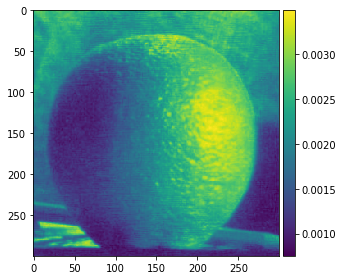

In [445]:
skio.imshow(orange)

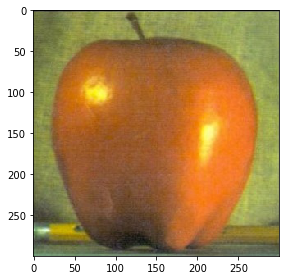

In [432]:
skio.imshow(sum(mona_laplace))

### 2.4 - Blending

In [ ]:
# Do in black or white first!

In [470]:
# Load in the orange and apple, make sure to 
apple = skio.imread('spline/apple.jpeg')/255
orange = skio.imread('spline/orange.jpeg')/255

In [471]:
# Build LaPlacian Stack for the Apple and the Orange
apple_lp = laplacian_stack(apple, 20, 5)
orange_lp = laplacian_stack(orange, 20, 5)

In [472]:
# Create a mask in this situation we will do a vertical one (might wanna adapt for horizontal later)
print(apple.shape, orange.shape)
vertical_seam_x = int(apple.shape[1]/2)
mask = np.zeros(apple.shape)
mask[:, :vertical_seam_x, :] = 1

(300, 300, 3) (300, 300, 3)


In [459]:
# Create a gaussian pyramid for this mask
Gmask = gaussian_stack(mask, 20, 5)

In [460]:
# Create a placeholder list to combine the resulting ones
resulting = []
#For level in all these levels
## do something something
## It is important that we do not forget to add in the lowest resolution level items at the end! 
## Also do not include the first picture, but I am sure that is fine

In [461]:
Gr = np.array(Gmask)
La = np.array(apple_lp)
Lb = np.array(orange_lp)

result = Gr * La + (1-Gr) * Lb


In [464]:
True == True == False

False

In [475]:
def multi_resolution_blending(image1, image2, mask, sigma, level, debug=False, gray=False, clip=False):
    """
    This function performs the multiresolution blending process using a LaPlacian stack of two images and a mask that determines what is being blended.
    Make sure to have the mask representing the part that shall be represented by image 1.
    image1, image2: (Matrix) Grey/Color images that are being blended
    mask: (Matrix) Same shape as image1, image2, where mask is representing ones of what part needs to be incorporated in the hybridized picture
    sigma: (int) The standard deviation for the gaussian blur used for the laplacian stack
    level: (int) Number of levels in the laPlacian stack
    debug (Bool) Debugging Mode
    gray: (Bool) If picture being put in is color and this is toggled on, the output will be gray.
    
    Returns: (Matrix) Hybridizied picture
    """
    assert image1.shape == image2.shape == mask.shape, "One of the shapes are off. Make sure that everything has the same dimension"
    lp1 = laplacian_stack(image1, level, sigma)
    lp2 = laplacian_stack(image2, level, sigma)
    Gmask = gaussian_stack(mask, level, sigma)
    Gr = np.array(Gmask)
    La = np.array(lp1)
    Lb = np.array(lp2)
    
    if gray or len(image1.shape)==2:
        result = Gr * La + (1-Gr) * Lb
        if clip:
            result = np.clip(result, a_min=0, a_max=1)
        return sum(result)
#     for i in range(3):
    result = Gr * La + (1-Gr) * Lb
    if clip:
        result = np.clip(result, a_min=0, a_max=1)
    return sum(result)
        
        
    
    

/Users/kevinmiao/opt/anaconda3/lib/python3.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:75: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


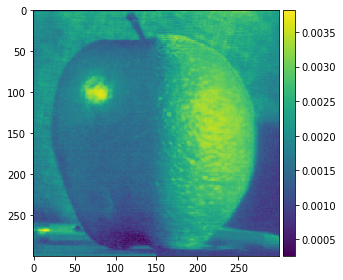

In [469]:
skio.imshow(multi_resolution_blending(apple, orange, mask, 3, 20))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


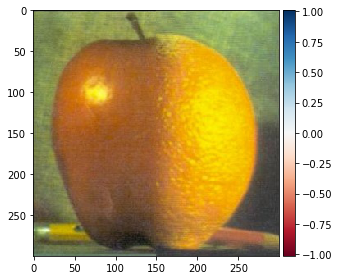

In [476]:
skio.imshow(multi_resolution_blending(apple, orange, mask, 3, 20))

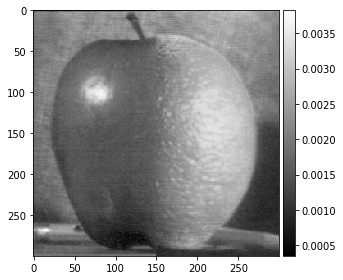

In [462]:
skio.imshow(sum(result), cmap=plt.cm.gray)